In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import SimpleITK as sitk
import cv2
from sklearn.utils.class_weight import compute_class_weight


image_dir = "/kaggle/input/ds-lung-tumor/Train-20250104T155611Z-001/Train"

# Functions

In [9]:
def load_nrrd(file_path):
    try:
        image = sitk.ReadImage(file_path)
        array = sitk.GetArrayFromImage(image)
        return array
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def load_all_images(df_images):
    display(df_images)

    nodule_images = []
    full_images   = []
    labels        = []

    for index, row in df_images.iterrows():
        noduleslice_filename = row['Nodule']
        noduleslice_path        = os.path.join(image_dir, noduleslice_filename)
        noduleslice_image_array = load_nrrd(noduleslice_path)
        nodule_images.append(noduleslice_image_array)

        fullslice_filename = row['Full_slice']
        fullslice_path        = os.path.join(image_dir, fullslice_filename)
        fullslice_image_array = load_nrrd(fullslice_path)
        full_images.append(fullslice_image_array)
        
        label = row['TumorClass']
        labels.append(label)
   
    labels = np.array(labels)

    return full_images, nodule_images, labels

def gamma_transform(image, lower_bound, upper_bound, gamma):
    clipped_image    = np.clip(image, lower_bound, upper_bound)
    hu_min = np.min(clipped_image)
    hu_max = np.max(clipped_image)
    normalized_image = (clipped_image - hu_min) / (hu_max - hu_min) # Normalize to [0, 1]
    gamma_corrected  = np.power(normalized_image, gamma) # Apply gamma transformation
    gamma_corrected  = gamma_corrected * (hu_max - hu_min) + hu_min # Scale back to the original HU range
    return gamma_corrected

def need_gamma_transformation(image, intensity_threshold, cdf_threshold=0.8):
    hist, bin_edges = np.histogram(image.ravel(), bins=256)
    cdf = np.cumsum(hist) / np.sum(hist)
    idx = (np.abs(bin_edges - (intensity_threshold))).argmin()
    if cdf[idx] >= cdf_threshold:
        return True
    else:
        return False

def extract_images(images, label_value, labels):
    image_list = []
    indices = [i for i, lbl in enumerate(labels) if lbl == label_value]
    for i in indices:
        image_list.append(images[i])
    return image_list

def plot_temp_images(images, labels_ids):
    fig, axes = plt.subplots(1, 7, figsize=(10, 3))
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(images[idx], cmap='gray')  # Display image
        ax.set_title(str(labels[labels_ids[idx]]))
        ax.title.set_size(14)
        ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

def gamma_transform(image, gamma):
    hu_min = np.min(image)
    hu_max = np.max(image)
    normalized_image = (image - hu_min) / (hu_max - hu_min) # Normalize to [0, 1]
    gamma_corrected  = np.power(normalized_image, gamma) # Apply gamma transformation
    # gamma_corrected = (gamma_corrected * 255).astype(np.uint8) # Scale back to the original HU range
    gamma_corrected  = gamma_corrected * (hu_max - hu_min) + hu_min # Scale back to the original HU range
    return gamma_corrected
    
def plot_chunck_images(images, labels_ids):
    fig, axes = plt.subplots(3, 7, figsize=(12, 6))
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(images[idx], cmap='gray')  # Display image
        ax.set_title(str(labels[labels_ids[idx]]))
        ax.title.set_size(14)
        ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

def plot_all_images(images, offset):
    if offset < 2300:
        fig, axes = plt.subplots(10, 10, figsize=(20, 20))
    else:
        fig, axes = plt.subplots(7, 9, figsize=(18, 18))
    for idx, ax in enumerate(axes.flatten()):
        i = offset+idx
        ax.imshow(images[i], cmap='gray')  # Display image
        ax.set_title(str(i) + ' ==> ' + str(labels[i]))
        ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

# Load Data

,Full_slice,Nodule,TumorClass
0,pat1_fullslice.nrrd,pat1_nodule.nrrd,5
1,pat2_fullslice.nrrd,pat2_nodule.nrrd,5
2,pat3_fullslice.nrrd,pat3_nodule.nrrd,2
3,pat4_fullslice.nrrd,pat4_nodule.nrrd,5
4,pat5_fullslice.nrrd,pat5_nodule.nrrd,4
...,...,...,...
2358,pat2368_fullslice.nrrd,pat2368_nodule.nrrd,2
2359,pat2369_fullslice.nrrd,pat2369_nodule.nrrd,2
2360,pat2387_fullslice.nrrd,pat2387_nodule.nrrd,5
2361,pat2399_fullslice.nrrd,pat2399_nodule.nrrd,5



Class Distribution:
TumorClass
3    1092
2     457
4     418
1     244
5     152
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


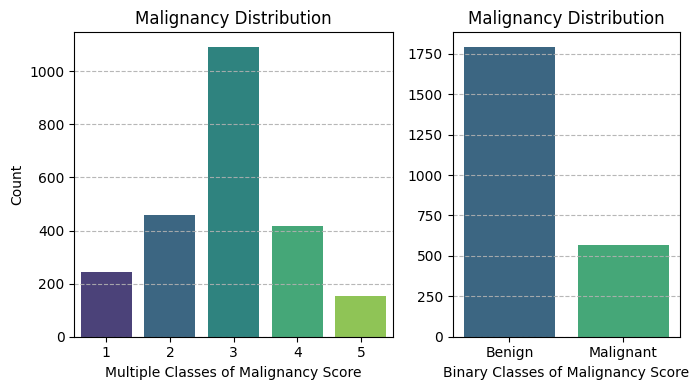

In [10]:
# Load data
df_images = pd.read_excel("/kaggle/input/ds-lung-tumor/dataset_lung.xlsx") # Read the CSV file
full_images, nodule_images, labels = load_all_images(df_images)

# Compute class distribution
class_counts = df_images['TumorClass'].value_counts()
benign_count = class_counts[1] + class_counts[2] + class_counts[3]
malignant_count = class_counts[4] + class_counts[5]

print("\nClass Distribution:")
print(class_counts)

# Create figure and gridspec
fig = plt.figure(figsize=(7, 4))  # Adjust figure size for better visualization
gs = gridspec.GridSpec(1, 2, width_ratios=[1.4, 1])  # Adjust width ratios (left plot 2.5x wider)

# First plot (left) - Multi-class malignancy distribution (Wider)
ax1 = plt.subplot(gs[0])
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis", ax=ax1)
ax1.set_title('Malignancy Distribution')
ax1.set_xlabel('Multiple Classes of Malignancy Score', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.9)

# Second plot (right) - Binary-class malignancy distribution (Narrower)
ax2 = plt.subplot(gs[1])
sns.barplot(x=['Benign', 'Malignant'], y=[benign_count, malignant_count], palette="viridis", ax=ax2)
ax2.set_title('Malignancy Distribution')
ax2.set_xlabel('Binary Classes of Malignancy Score', fontsize=10)
ax2.grid(axis='y', linestyle='--', alpha=0.9)

# Adjust layout
plt.tight_layout()

plt.savefig("malignancy_distribution.png", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
# Compute class weights
unique_classes = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=labels)
class_weight_dict = {i: np.round(weight, 3) for i, weight in enumerate(class_weights, 1)}  # Label starts from 1
print("Computed Class Weights:", class_weight_dict)

binary_labels = []
for label in labels:
    if label <= 3:
        binary_labels.append(0)
    else:
        binary_labels.append(1)

# Compute Binary class weights
unique_classes = np.unique(binary_labels)
binary_class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=binary_labels)
binary_class_weight_dict = {i: np.round(weight, 3) for i, weight in enumerate(binary_class_weights, 1)}  # Label starts from 1
print("Computed ‌Binary Class Weights:", binary_class_weight_dict)


# Display Some Full and Nodule Slices

In [ ]:
# full_noise_ids = [336, 1595, 1596, 2113]
# full_haze_ids  = [254, 798, 799, 893, 895, 950, 988, 1364, 1630, 1908, 1909, 1935, 2058, 2224]

full_samples_ids = [18, 25, 20, 171, 159, 278, 300, 336, 390, 713, 792, 801,
                   802, 871, 890, 915, 1056, 1086, 1596, 1753, 1976, 2060, 2113, 2224]
labels_ids = []
full_samples = []
for idx, img in enumerate(full_images):
    if idx in full_samples_ids:
        full_samples.append(img)
        labels_ids.append(idx)
    
plot_chunck_images(full_samples, labels_ids)

In [ ]:
# nodule_noise_ids = [802, 1073, 1144, 1166, 1364, 1595, 1596, 1613]
# nodule_haze_ids  = []
labels_ids = []
nodule_samples = []
nodule_samples_ids = [14, 20, 87, 67, 92, 180, 135, 189, 295, 304, 497, 616, 488, 750, 
                     791, 1509, 1596, 1878, 2018, 2308, 2356]
for idx, img in enumerate(nodule_images):
    if idx in nodule_samples_ids:
        nodule_samples.append(img)
        labels_ids.append(idx)

print(len(nodule_samples_ids))
plot_chunck_images(nodule_samples, labels_ids)

# Shape Distributions

In [ ]:
df_dataset = pd.read_csv("/kaggle/input/ds-lung-tumor/dataset_lung_augmented.csv") # Read the CSV file
unique_nodule, count_nodule = np.unique(df_dataset['nodule_shape'], return_counts=True)
# print(len(unique_nodule))
# print(unique_nodule)
# print(count_nodule)

n = 25
nodules_major = count_nodule[count_nodule > n]
indices = np.where(count_nodule > n)[0]

x = unique_nodule[indices]
y = count_nodule[indices]

# Create the bar plot
plt.figure(figsize=(10, 5))  # Adjust figure size as needed
plt.bar(x, y, color='skyblue')

# Add labels and title
plt.xlabel("Nodule Shapes", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Nodule Shapes")

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=90, ha='right')

# Add grid lines (optional)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Data Preprocessing

In [ ]:
# full_noise_ids = [336, 1595, 1596, 2113]
# full_haze_ids  = [254, 798, 799, 893, 895, 950, 988, 1364, 1630, 1908, 1909, 1935, 2058, 2224]
full_haze_ids  = [254, 336, 895, 1364, 1908, 1909, 2361]

labels_ids = []
full_samples = []
for idx, img in enumerate(full_images):
    if idx in full_haze_ids:
        full_samples.append(img)
        labels_ids.append(idx)

plot_temp_images(full_samples, labels_ids)

min_hu = -1000
max_hu = +500
# wc = -600
# ww = 1500
full_modified_slices = []
for img in full_samples:

    # Mist reduction and gamma transformation
    temp_slice = np.clip(img, min_hu, max_hu)
    temp_slice = cv2.normalize(temp_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    temp_slice = gamma_transform(temp_slice, gamma=1.35)
    
    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    temp_slice = np.uint8(temp_slice)
    temp_slice = clahe.apply(temp_slice)
    
    full_modified_slices.append(temp_slice)

plot_temp_images(full_modified_slices, labels_ids)

# full_slices = np.array(full_modified_slices)

In [ ]:
nodule_noise_ids = [67, 172, 189, 214, 281, 426, 833]
# nodule_noise_ids = [187, 1052, 392, 189, 569, 1123, 233]

# nodule_haze_ids  = []
labels_ids = []
nodule_samples = []
# nodule_samples_ids = [14, 20, 87, 67, 92, 180, 135, 189, 295, 304, 497, 616, 488, 750, 
#                      791, 1509, 1596, 1878, 2018, 2308, 2356]
for idx, img in enumerate(nodule_images):
    if idx in nodule_noise_ids:
        nodule_samples.append(img)
        labels_ids.append(idx)
        
plot_temp_images(nodule_samples, labels_ids)

min_hu = -1000
max_hu = +500
# wc = -600
# ww = 1500
nodule_modified_slices = []
for img in nodule_samples:

    # Mist reduction and gamma transformation
    temp_slice = np.clip(img, min_hu, max_hu)
    temp_slice = cv2.normalize(temp_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    temp_slice = gamma_transform(temp_slice, gamma=1.35)
    
    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    temp_slice = np.uint8(temp_slice)
    temp_slice = clahe.apply(temp_slice)
    
    temp_slice = cv2.resize(temp_slice, (52, 52))
    
    nodule_modified_slices.append(temp_slice)

plot_temp_images(nodule_modified_slices, labels_ids)

In [11]:
min_hu = -1000
max_hu = +500
full_all_modified_slices = []
for img in full_images:

    # Mist reduction and gamma transformation
    temp_slice = np.clip(img, min_hu, max_hu)
    temp_slice = cv2.normalize(temp_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    temp_slice = gamma_transform(temp_slice, gamma=1.35)
    
    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    temp_slice = np.uint8(temp_slice)
    temp_slice = clahe.apply(temp_slice)

    full_all_modified_slices.append(temp_slice)

# offsets = list(range(0, 2400, 100))
# for offset in offsets:
#     plot_all_images(full_all_modified_slices, offset)

In [12]:
min_hu = -1000
max_hu = +500
nodule_all_modified_slices = []
for img in nodule_images:

    # Mist reduction and gamma transformation
    temp_slice = np.clip(img, min_hu, max_hu)
    temp_slice = cv2.normalize(temp_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    temp_slice = gamma_transform(temp_slice, gamma=1.35)
    
    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    temp_slice = np.uint8(temp_slice)
    temp_slice = clahe.apply(temp_slice)

    temp_slice = cv2.resize(temp_slice, (52, 52))

    nodule_all_modified_slices.append(temp_slice)
    
# offsets = list(range(0, 2400, 100))
# for offset in offsets:
#     plot_all_images(nodule_all_modified_slices, offset)

# Laplacian Analysis

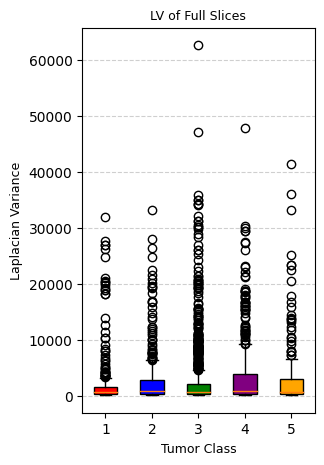

In [39]:
# Define colors for each class
colors = ['red', 'blue', 'green', 'purple', 'orange']

laplacian_full_dict = {i: [] for i in range(1, 6)}

# Compute Laplacian variance for each class
for i, lbl in enumerate(labels):
    laplacian_var_full = cv2.Laplacian(full_all_modified_slices[i], cv2.CV_64F).var()
    laplacian_full_dict[lbl].append(laplacian_var_full)

# Plot all boxplots on a single figure
fig, ax = plt.subplots(figsize=(3, 5))

# Create boxplots
box = ax.boxplot(
    [laplacian_full_dict[i] for i in range(1, 6)],
    # vert=False,
    patch_artist=True,  # Fill with color
    labels=[f"{i}" for i in range(1, 6)]
)

# Apply colors to each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Labels and title
ax.set_title("LV of Full Slices", fontsize=9)
ax.set_xlabel("Tumor Class", fontsize=9)
ax.set_ylabel("Laplacian Variance", fontsize=9)
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


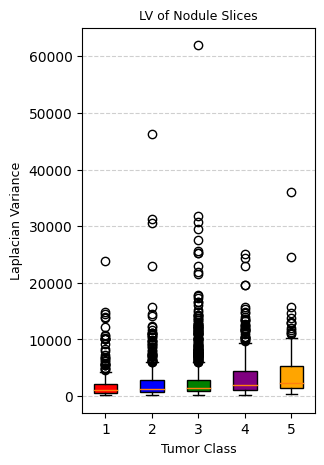

In [40]:
# Define colors for each class
colors = ['red', 'blue', 'green', 'purple', 'orange']

laplacian_nodule_dict = {i: [] for i in range(1, 6)}

# Compute Laplacian variance for each class
for i, lbl in enumerate(labels):
    laplacian_var_nodule = cv2.Laplacian(nodule_all_modified_slices[i], cv2.CV_64F).var()
    laplacian_nodule_dict[lbl].append(laplacian_var_nodule)

# Plot all boxplots on a single figure
fig, ax = plt.subplots(figsize=(3, 5))

# Create boxplots
box = ax.boxplot(
    [laplacian_nodule_dict[i] for i in range(1, 6)],
    # vert=False,
    patch_artist=True,  # Fill with color
    labels=[f"{i}" for i in range(1, 6)]
)

# Apply colors to each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Labels and title
ax.set_title("LV of Nodule Slices", fontsize=9)
ax.set_xlabel("Tumor Class", fontsize=9)
ax.set_ylabel("Laplacian Variance", fontsize=9)
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


In [ ]:
# Compute Laplacian variance for all images
laplacian_values_full = []
for img in full_all_modified_slices:
    # Compute Laplacian and its variance
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    laplacian_values_full.append(laplacian_var)
    
laplacian_values_nodule = []
for img in nodule_all_modified_slices:
    # Compute Laplacian and its variance
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    laplacian_values_nodule.append(laplacian_var)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 4))  # (1 row, 2 columns), Adjust figure size

# First plot (left) - Multi-class malignancy distribution
axes[0].hist(laplacian_values_full, bins=30, color='blue', edgecolor='black')
axes[0].set_title('Full Images')
axes[0].set_xlabel('Laplacian Variance', fontsize=11)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].grid(linestyle='--', alpha=0.9)

# Second plot (right) - Binary-class malignancy distribution
axes[1].hist(laplacian_values_nodule, bins=30, color='blue', edgecolor='black')
axes[1].set_title('Nodule Images')
axes[1].set_xlabel('Laplacian Variance', fontsize=11)
axes[1].grid(linestyle='--', alpha=0.9)

# Adjust layout to prevent overlapping
fig.tight_layout()

# Save the figure (optional)
fig.savefig("Laplacian_Distribution.png", dpi=300, bbox_inches='tight')

# Show the plots
plt.show()

In [ ]:
for p in range(90, 100):
    noisy_threshold_full = np.percentile(laplacian_values_full, p)
    noise_idx_full = []
    for idx, image in enumerate(full_all_modified_slices):
        lap_var = cv2.Laplacian(image, cv2.CV_64F).var()
        if lap_var > noisy_threshold_full:
            noise_idx_full.append(idx)
    print(f"p = {p}, Number of full images = {len(noise_idx_full)}")

print('=' * 30)

for p in range(90, 100):
    noisy_threshold_nodule = np.percentile(laplacian_values_nodule, p)
    noise_idx_nodule = []
    for idx, image in enumerate(nodule_all_modified_slices):
        lap_var = cv2.Laplacian(image, cv2.CV_64F).var()
        if lap_var > noisy_threshold_nodule:
            noise_idx_nodule.append(idx)
    print(f"p = {p}, Number of nodule images = {len(noise_idx_nodule)}")

In [ ]:
# Full Images
noisy_threshold_full = np.percentile(laplacian_values_full, 99)
print(noisy_threshold_full)

noise_list_full = []
noise_idx_full = []
for idx, image in enumerate(full_all_modified_slices):
    lap_var = cv2.Laplacian(image, cv2.CV_64F).var()
    if lap_var > noisy_threshold_full:
        noise_list_full.append(image)
        noise_idx_full.append(idx)

if len(noise_idx_full) > 0:
    plot_chunck_images(noise_list_full, noise_idx_full)
    print(noise_idx_full)

# Nodule Images
noisy_threshold_nodule = np.percentile(laplacian_values_nodule, 99)
print(noisy_threshold_nodule)

noise_list_nodule = []
noise_idx_nodule = []
for idx, image in enumerate(nodule_all_modified_slices):
    lap_var = cv2.Laplacian(image, cv2.CV_64F).var()
    if lap_var > noisy_threshold_nodule:
        noise_list_nodule.append(image)
        noise_idx_nodule.append(idx)

if len(noise_idx_nodule) > 0:
    plot_chunck_images(noise_list_nodule, noise_idx_nodule)
    print(noise_idx_nodule)

In [ ]:
noise_list_images = []
noise_list_ids = [932, 1364, 1365, 1595, 1596, 1809, 2217]

for idx, img in enumerate(full_all_modified_slices):
    if idx in noise_list_ids:
        noise_list_images.append(img)
plot_temp_images(noise_list_images, noise_list_ids)

noise_list_images = []
noise_list_ids = [392, 1179, 1181, 1433, 1613, 1671, 2059]

for idx, img in enumerate(nodule_all_modified_slices):
    if idx in noise_list_ids:
        noise_list_images.append(img)
plot_temp_images(noise_list_images, noise_list_ids)

In [ ]:
# Compute Laplacian variance for all images


# Assuming 'variances' is a list of Laplacian variances for all images
plt.hist(laplacian_values, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Laplacian Variances')
plt.xlabel('Laplacian Variance')
plt.ylabel('Number of Images')
plt.show()

# Calculate the 95th percentile
noisy_threshold = np.percentile(laplacian_values, 99)

noise_list = []
noise_labels = []
for idx, image in enumerate(full_images):
    lap_var = cv2.Laplacian(image, cv2.CV_64F).var()
    if lap_var > noisy_threshold:
        noise_list.append(image)
        noise_labels.append(idx)

print(len(noise_list))
plot_chunck_images(noise_list, noise_labels)

In [ ]:
# Compute Laplacian variance for all images
laplacian_values = []
for img in full_all_modified_slices:
    # Compute Laplacian and its variance
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    laplacian_values.append(laplacian_var)

# Assuming 'variances' is a list of Laplacian variances for all images
plt.hist(laplacian_values, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Laplacian Variances')
plt.xlabel('Laplacian Variance')
plt.ylabel('Number of Images')
plt.show()

# Calculate the 99th percentile
noisy_threshold = np.percentile(laplacian_values, 99)

full_noise_list = []
full_noise_labels = []
for idx, image in enumerate(full_all_modified_slices):
    lap_var = cv2.Laplacian(image, cv2.CV_64F).var()
    if lap_var > noisy_threshold:
        full_noise_list.append(image)
        full_noise_labels.append(idx)

print(len(full_noise_labels))
plot_chunck_images(full_noise_list, full_noise_labels)

In [ ]:
# Compute Laplacian variance for all images
laplacian_values = []
for img in nodule_all_modified_slices:
    # Compute Laplacian and its variance
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    laplacian_values.append(laplacian_var)

# Assuming 'variances' is a list of Laplacian variances for all images
plt.hist(laplacian_values, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Laplacian Variances')
plt.xlabel('Laplacian Variance')
plt.ylabel('Number of Images')
plt.show()

print(f"Minimum = {np.min(laplacian_values)}")
print(f"Maximum = {np.max(laplacian_values)}")
print(f"Mean    = {np.mean(laplacian_values)}")
print(f"st. dev = {np.std(laplacian_values)}")


# Calculate the 99th percentile
noisy_threshold = np.percentile(laplacian_values, 99)
print(f"Noise Threshold: {noisy_threshold}")

nodule_noise_list = []
nodule_noise_labels = []
for idx, image in enumerate(nodule_all_modified_slices):
    lap_var = cv2.Laplacian(image, cv2.CV_64F).var()
    if lap_var > noisy_threshold:
        print(lap_var)
        nodule_noise_list.append(image)
        nodule_noise_labels.append(idx)

print(len(nodule_noise_labels))
if len(nodule_noise_labels) > 0:
    plot_chunck_images(nodule_noise_list, nodule_noise_labels)